In [1]:

import numpy as np
import xarray as xr
from matplotlib import pyplot as plt


import pickle as pkl
from utils import *

import pandas as pd
import seaborn as sns

import cartopy.crs as ccrs


In [2]:
n_modes = 5
modes = 1 + np.arange(n_modes)



scenarios = [585, 370, 245, 126]

dmds = {}
for ssp in scenarios:
    with open(f'./models/DMD/tas{ssp}.pkl', 'rb') as f:
        dmd = pkl.load(f)
        dmds[ssp] = dmd

xr_train_clim = xr.open_dataset('./data/train_val/outputs_historical.nc').mean(dim='member')
xr_test_clim = xr.open_dataset(f'./data/train_val/outputs_ssp126.nc').mean(dim='member')


tas_all = xr.concat([xr_train_clim, xr_test_clim], dim = 'time').tas
lat_data = tas_all.lat
lon_data = tas_all.lon


# a small change to plotting function
plotmap = lambda mode, ax, amax: make_plot(mode, lat_data, lon_data, fig, ax, mode_num=0,
                                           min_val=-amax, max_val=amax, colorbar=True)


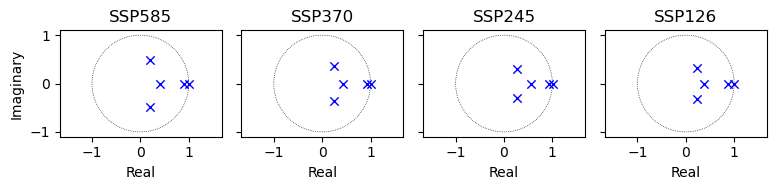

In [3]:


fig, ax = plt.subplots(1,4, figsize=(8,2), sharey = True)

for i, (ssp, dmd) in enumerate(dmds.items()):

    ax[i].scatter(np.real(dmd.eigs), np.imag(dmd.eigs), marker = 'x', color = 'blue', lw = 1)
    ax[i].set_xlim([-1,1])
    ax[i].set_ylim([-1,1])
    ax[i].axis('equal')
    # ax[i].set_axis_off()
    ax[i].set_title(f'SSP{ssp}')
    theta = np.linspace(0, 2*np.pi, 100)
    # Parametric equations for the unit circle
    x = np.cos(theta)
    y = np.sin(theta)
    ax[i].plot(x,y,c = 'k', lw = .5, linestyle = 'dotted')
    ax[i].set_xlabel('Real')

ax[0].set_ylabel('Imaginary')

plt.tight_layout()

plt.savefig('plots/eigenvalues_dmd.pdf')




In [4]:
for i, (ssp, dmd) in enumerate(dmds.items()):
    print(ssp)
    print(dmd.eigs)
    

585
[0.20843972+0.48290354j 0.20843972-0.48290354j 1.0128745 +0.j
 0.897349  +0.j         0.41029477+0.j        ]
370
[1.0104252 +0.j         0.92472327+0.j         0.24230623+0.36414313j
 0.24230623-0.36414313j 0.42568707+0.j        ]
245
[1.004695  +0.j         0.9357674 +0.j         0.26285842+0.29071397j
 0.26285842-0.29071397j 0.55143076+0.j        ]
126
[0.9972876 +0.j         0.8792407 +0.j         0.23027189+0.31639567j
 0.23027189-0.31639567j 0.38301736+0.j        ]


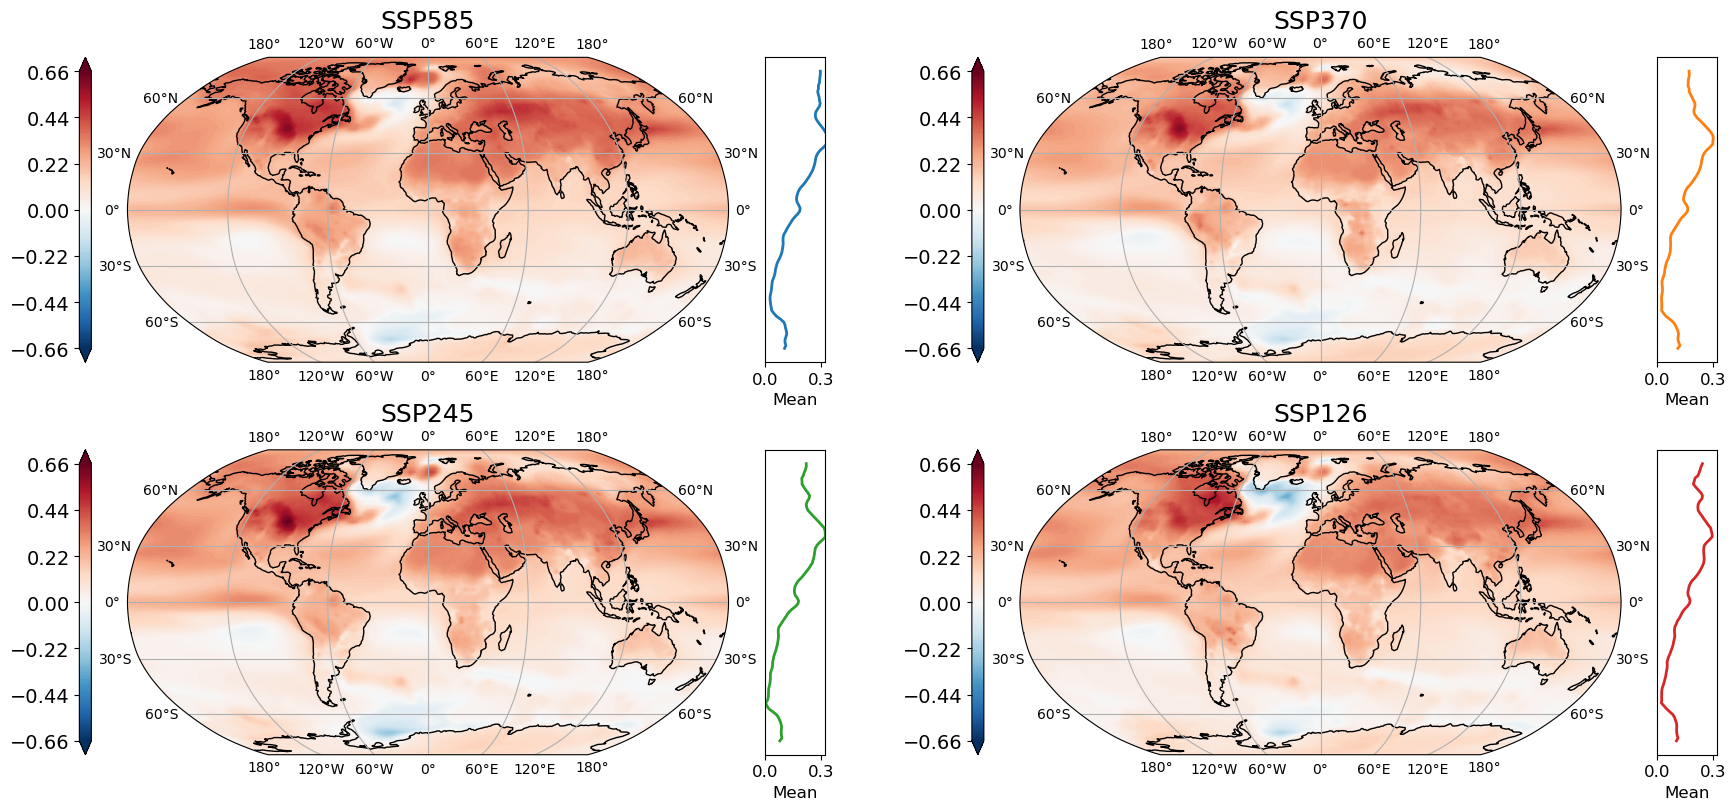

In [5]:
fig, ax = plt.subplots(2, 2, figsize=(18,8), 
                       subplot_kw={'projection': ccrs.Robinson()})

caxs = []
for axi in ax.flatten():
    # caxs.append(axi.inset_axes((1.02, 0, 0.1, 1)))
    caxs.append(axi.inset_axes((1.06, 0, 0.1, 1)))


# Global warming modes
js = [(0,0),(0,1),(1,0),(1,1)]

colors = ['tab:blue','tab:orange','tab:green','tab:red'] 
mapping = {126: [0,1], 245: [0,1], 370: [0,1], 585: [2,3]}
for i, (ssp, mode) in enumerate(dmds.items()):
    X0 = get_real(dmds, ssp, mapping[ssp])
    for j in range(len(js)):
        if i == j:
            a = 1
        else:
            a = 0
        caxs[j].plot(np.mean(np.real(X0).reshape(96, 144), axis = 1), lat_data, color = colors[i], alpha = a, lw = 2)
        caxs[j].set_yticks([])
        caxs[j].set_xlim([0,.32])
        caxs[j].set_xticks([0,.3])
        caxs[j].set_xlabel('Mean',fontsize=12)
        caxs[j].tick_params(axis='x',labelsize=12)


amax = max([np.max([get_real(dmds, ssp, mode).max(), -get_real(dmds, ssp, mode).min()]) for (ssp, mode) in mapping.items()])
for i, (ssp, mode) in enumerate(dmds.items()):
    X0 = get_real(dmds, ssp, mapping[ssp])
    plotmap(X0, ax[js[i]], amax)
    # module1 = np.abs(dmdcs_hankel[ssp].eigs[mapping[ssp][0]])
    # module2 = np.abs(dmdcs_hankel[ssp].eigs[mapping[ssp][1]])
    # ax[js[i]].set_title(r"SSP{ssp} - $\lambda_1$ = {module1:.2f}, $\lambda_2$ = {module2:.2f}".format(ssp=ssp,  module1=module1, module2 = module2),
    #                     fontdict = {'fontsize':18})
    ax[js[i]].set_title(f"SSP{ssp}",fontdict = {'fontsize':18})



plt.tight_layout()
plt.savefig('plots/warming_trend_dmd.pdf', bbox_inches = 'tight')

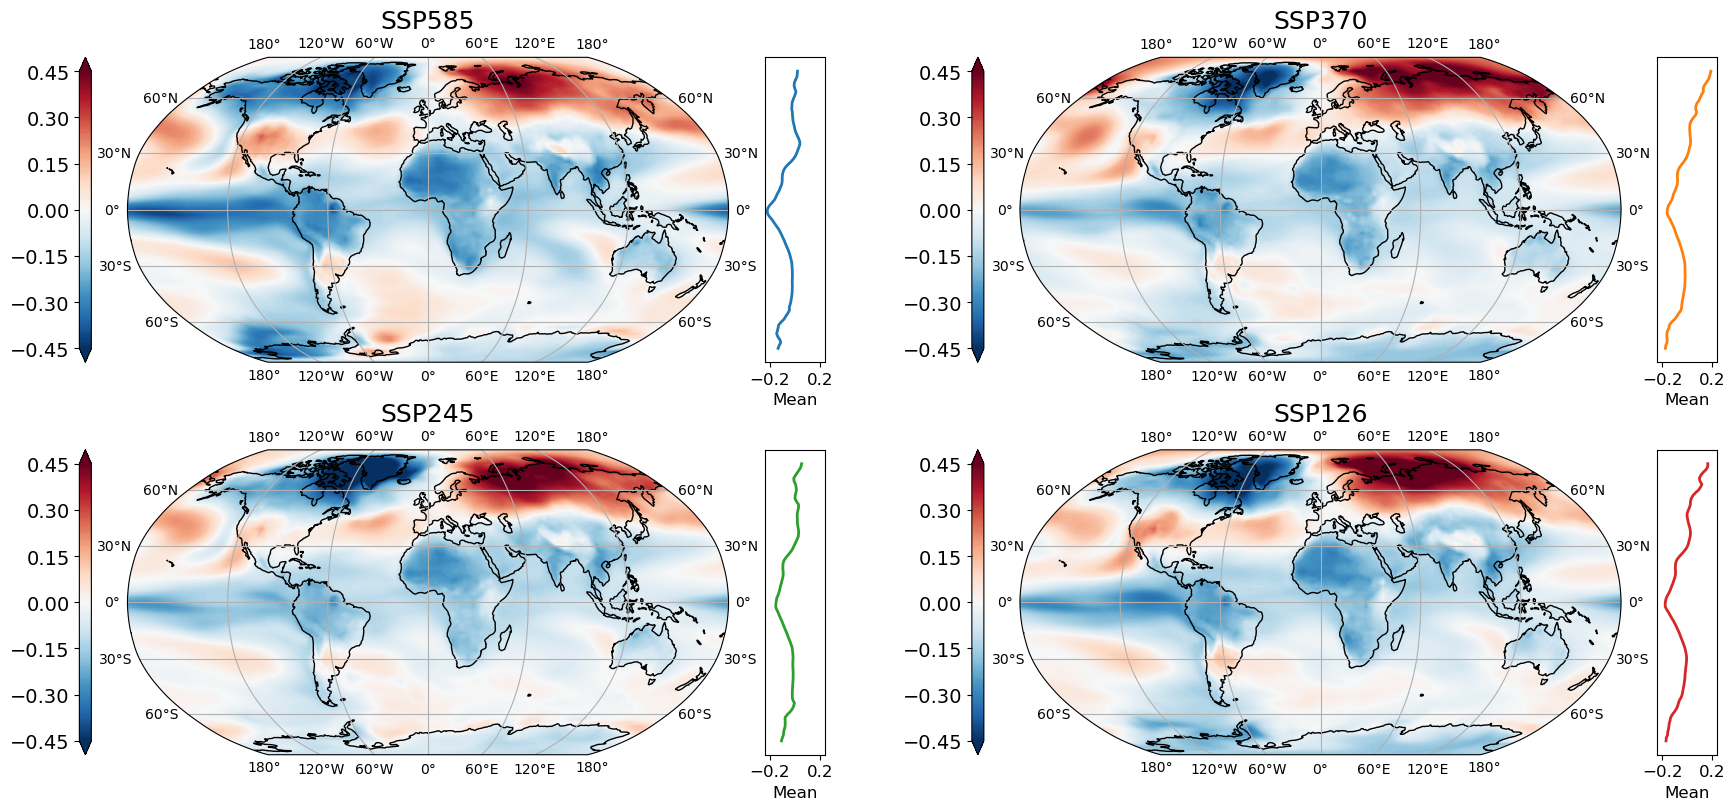

In [6]:
fig, ax = plt.subplots(2, 2, figsize=(18,8), 
                       subplot_kw={'projection': ccrs.Robinson()})

caxs = []
for axi in ax.flatten():
    # caxs.append(axi.inset_axes((1.02, 0, 0.1, 1)))
    caxs.append(axi.inset_axes((1.06, 0, 0.1, 1)))

js = [(0,0),(0,1),(1,0),(1,1)]
mapping = {126: [2,3], 245: [2,3], 370: [2,3], 585: [0,1]}
colors = ['tab:blue','tab:orange','tab:green','tab:red'] 
i=0
for ssp in scenarios:
    dmd = dmds[ssp]
    X0 = 2*np.real(dmd.modes[:,mapping[ssp][0]]*dmd.amplitudes[mapping[ssp][0]]) 
    for j in range(len(js)):
        if i == j:
            a = 1
        else:
            a = 0
        caxs[j].plot(np.mean(np.real(X0).reshape(96, 144), axis = 1), lat_data, color = colors[i], alpha = a, lw = 2)
        caxs[j].set_yticks([])
        caxs[j].set_xlim([-.24,.24])
        caxs[j].set_xticks([-.2,.2])
        caxs[j].set_xlabel('Mean',fontsize=12)
        caxs[j].tick_params(axis='x',labelsize=12)
    i+=1


i=0
for i, ssp in enumerate(scenarios):
    dmd = dmds[ssp]
    X0 = 2*np.real(dmd.modes[:,mapping[ssp][0]]*dmd.amplitudes[mapping[ssp][0]]) 
    plotmap(X0, ax[js[i]], .45) #did not use max val here because the max val is >1 and washes out the color
    ax[js[i]].set_title(f"SSP{ssp}", fontdict = {'fontsize':18})
    i+=1

plt.tight_layout()
plt.savefig('plots/enso_dmd.pdf', bbox_inches = 'tight')

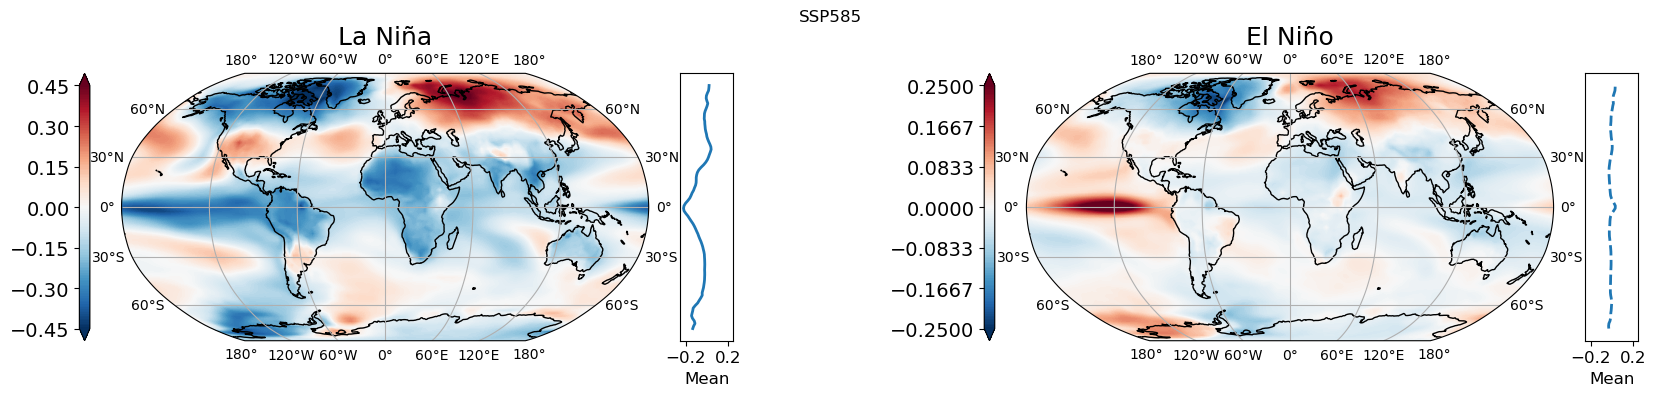

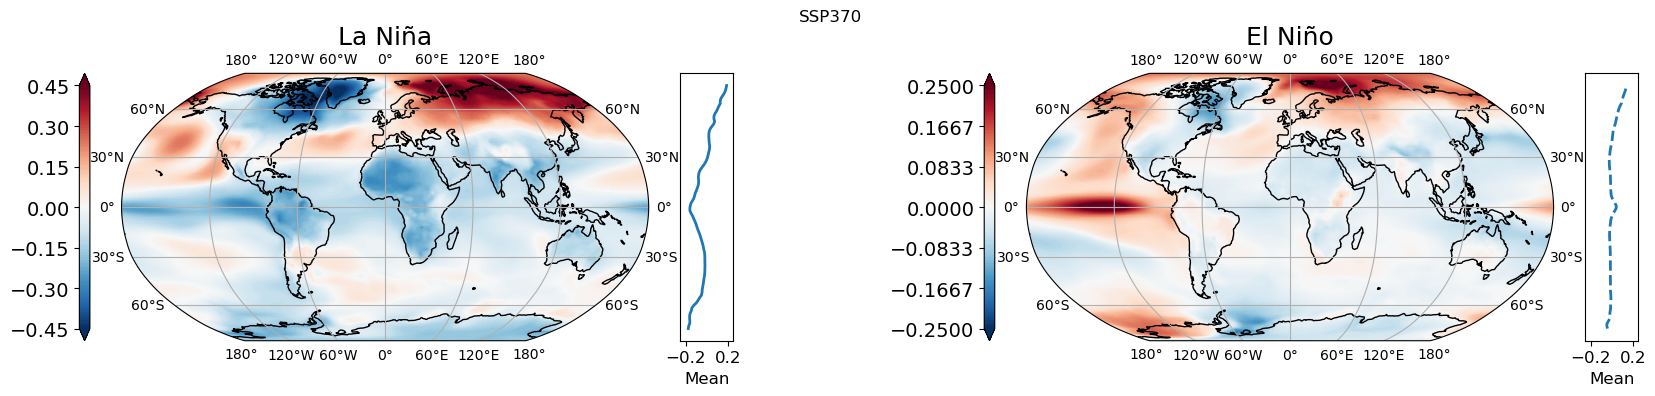

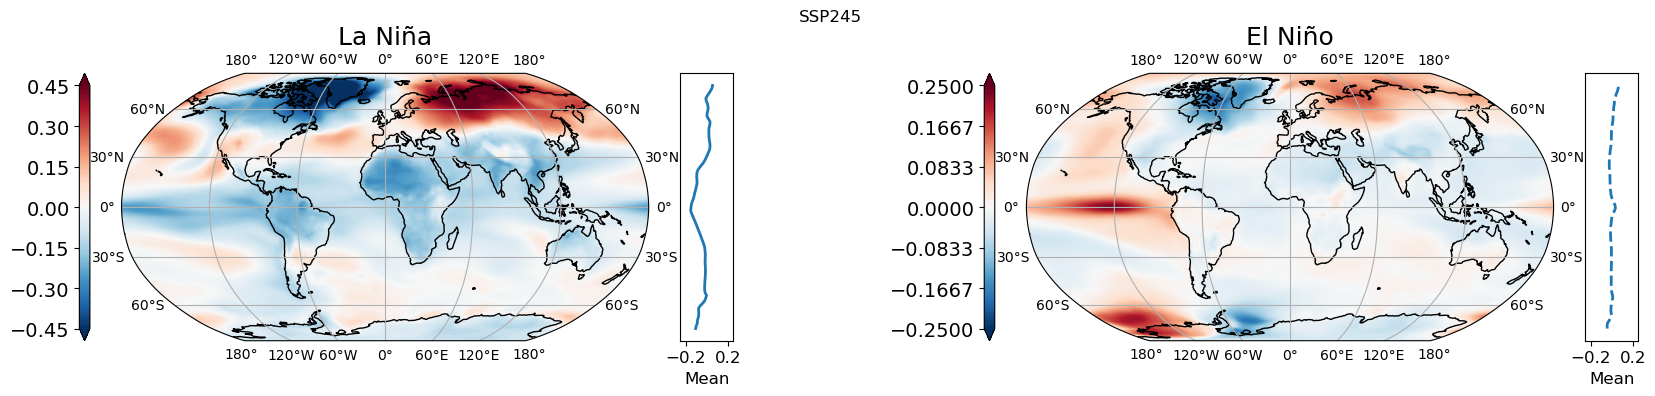

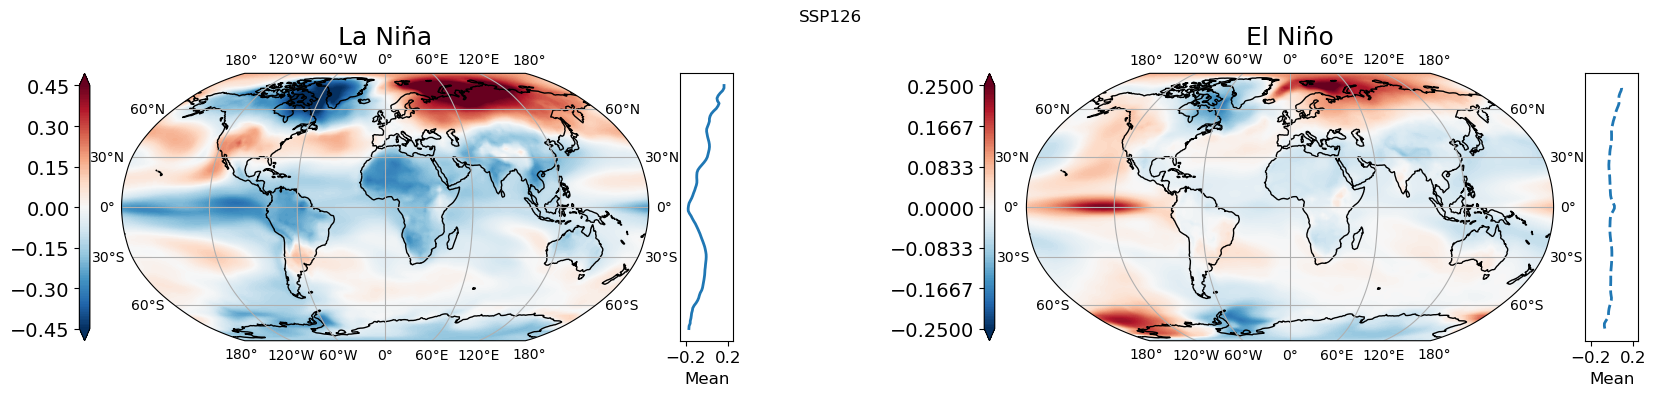

In [7]:
for ssp in scenarios:

    fig, ax = plt.subplots(1, 2, figsize=(18,4), 
                        subplot_kw={'projection': ccrs.Robinson()})

    caxs = []
    for axi in ax.flatten():
        # caxs.append(axi.inset_axes((1.02, 0, 0.1, 1)))
        caxs.append(axi.inset_axes((1.06, 0, 0.1, 1)))


    dmd = dmds[ssp]

    js = [(0,0),(0,1),(1,0),(1,1)]
    mapping = {126: [2,3], 245: [2,3], 370: [2,3], 585: [0,1]}
    linestyles = ['solid','dashed'] 
    for pwr in range(2):
        X0 = 2*np.real(dmd.modes[:,mapping[ssp][0]]*(dmd.eigs[mapping[ssp][0]]) **pwr*dmd.amplitudes[mapping[ssp][0]]) 
        for j in range(2):
            if pwr == j:
                a = 1
            else:
                a = 0
            caxs[j].plot(np.mean(np.real(X0).reshape(96, 144), axis = 1), lat_data, color = 'tab:blue', alpha = a, lw = 2, linestyle = linestyles[pwr])
            caxs[j].set_yticks([])
            caxs[j].set_xlim([-.25,.25])
            caxs[j].set_xticks([-.2,.2])
            caxs[j].set_xlabel('Mean',fontsize=12)
            caxs[j].tick_params(axis='x',labelsize=12)

    for pwr, c_max in zip([0,1],[.45,.25]):
        dmd = dmds[ssp]
        X0 = 2*np.real(dmd.modes[:,mapping[ssp][0]]*(dmd.eigs[mapping[ssp][0]]) **pwr*dmd.amplitudes[mapping[ssp][0]]) 
        plotmap(X0, ax[pwr], c_max) #did not use max val here because the max val is >1 and washes out the color
        module1 = np.real(dmds[ssp].eigs[mapping[ssp][0]])
        module2 = np.imag(dmds[ssp].eigs[mapping[ssp][0]])

    # plt.suptitle('SSP585', fontsize=18)
    ax[0].set_title(r"La Niña", fontdict = {'fontsize':18})
    ax[1].set_title(r"El Niño", fontdict = {'fontsize':18})

    fig.suptitle(f'SSP{ssp}', fontdict = {'size':18})
    plt.tight_layout()

585
0.1851475505150897
370
0.1565544908610207
245
0.1330018641687011
126
0.14986937680625378


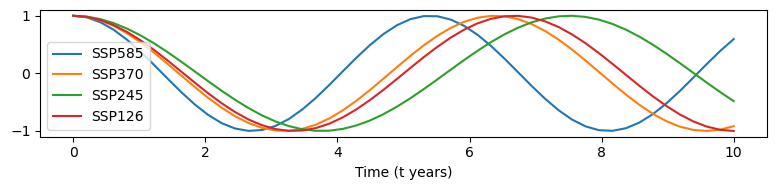

In [8]:
#frequency of oscillation
mapping = {126: 2, 245: 2, 370: 2, 585: 0}

for i, (ssp,dmd) in enumerate(dmds.items()):
    m = mapping[ssp]
    print(ssp)
    print(np.real(-1j*np.log(dmd.eigs[m]/np.abs(dmd.eigs[m]))/(2*np.pi)))

#frequency of oscillation
plt.figure(figsize = (8,2))
mapping = {126: 2, 245: 2, 370: 2, 585: 0}
xs = np.linspace(0,10,50)
for i, (ssp,dmd) in enumerate(dmds.items()):
    m = mapping[ssp]
    plt.plot(xs, np.real(np.exp(xs*np.log(dmd.eigs[m]/np.abs(dmd.eigs[m])))), label = f'SSP{ssp}')

plt.legend()
plt.xlabel('Time (t years)')
# plt.ylabel(r'$e^{i \omega_m t}$')
plt.tight_layout()
plt.savefig('plots/eval_oscillation_dmd.pdf')